In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
import seaborn as sns
import tensorflow as tf

%matplotlib inline

In [6]:
df = pd.read_csv('daily-min-temperatures.csv')

In [7]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [9]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


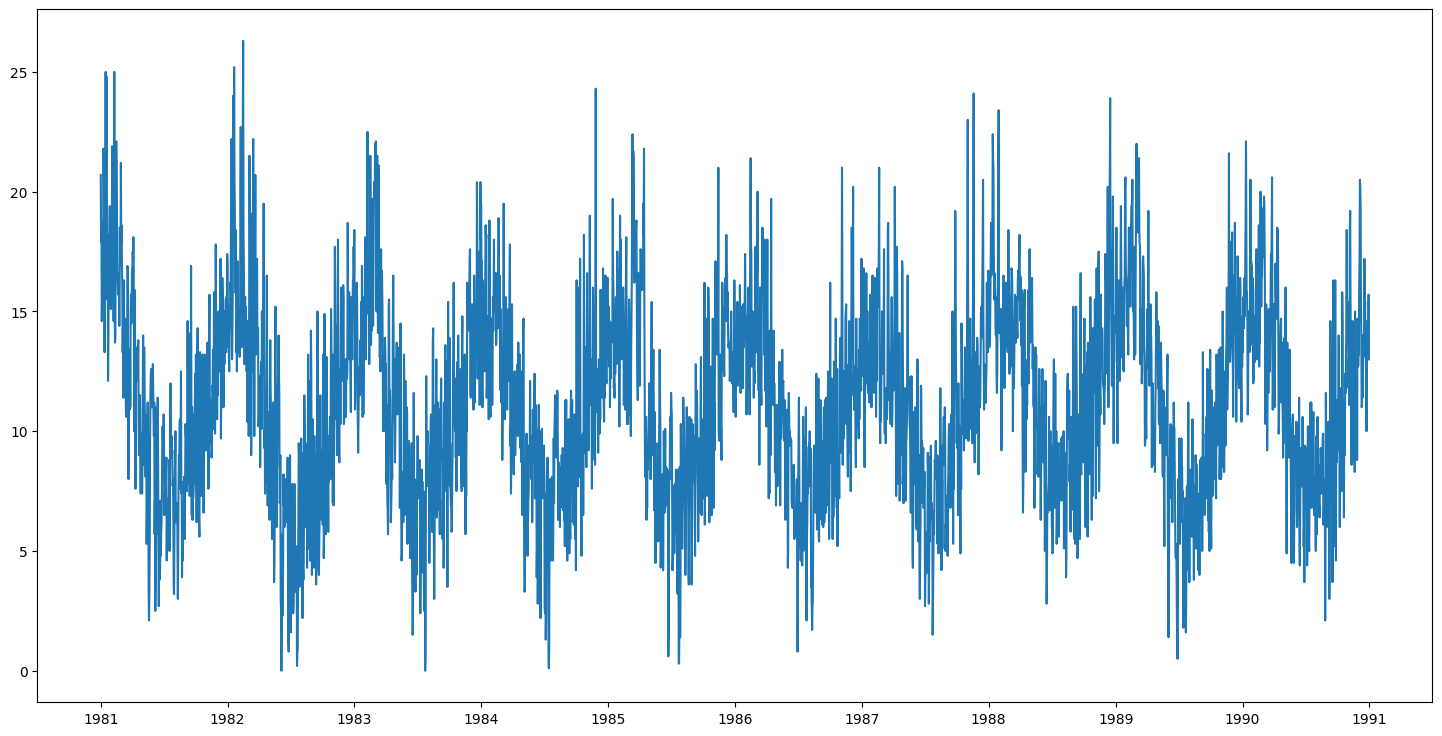

In [10]:
plt.figure(figsize=(18,9))
plt.plot(df.index, df["Temp"], linestyle="-")
plt.xlabel=('Date')
plt.ylabel=('Temp')
plt.show();

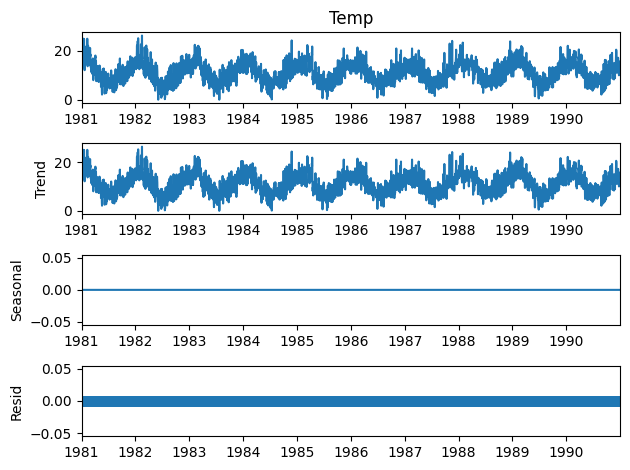

In [11]:
a = seasonal_decompose(df["Temp"], model = "add", period=1)
a.plot();

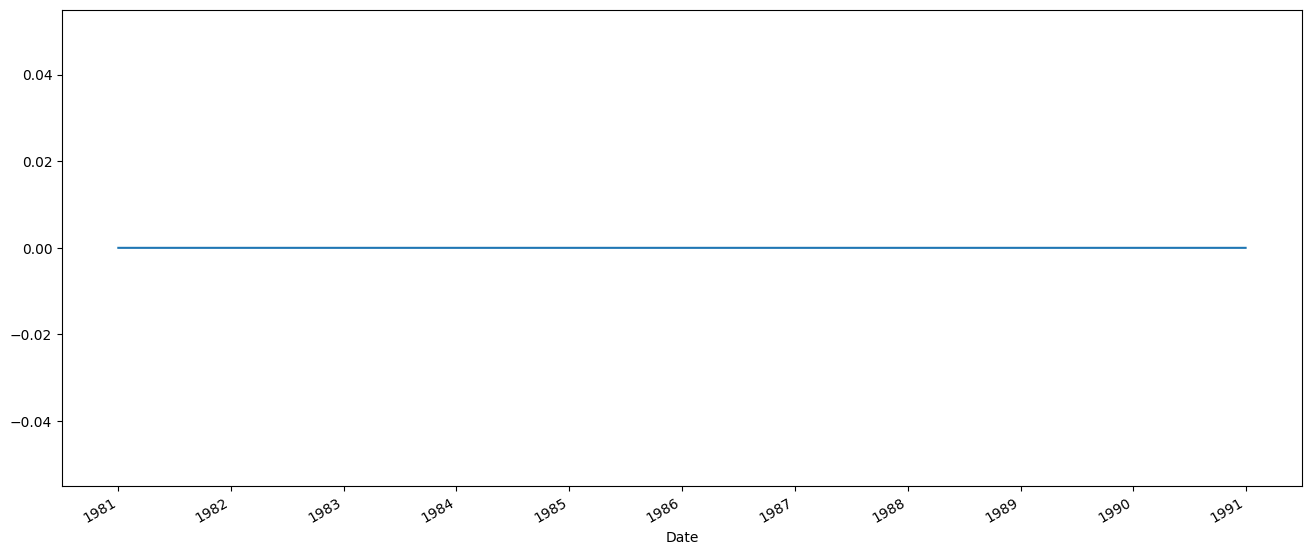

In [12]:
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [13]:
adf_test = adfuller(df["Temp"])
print('p-value = ' + str(adf_test[1]))

if adf_test[1] > 0.05:
    print('it is not a stationary process')
else:
    print('it is a stationary process')

p-value = 0.0002470826300360994
it is a stationary process


In [14]:
test_data_size = 92
train_data = df[:len(df)-test_data_size]
print(train_data)
test_data = df[len(df)-test_data_size:]

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
...          ...
1990-09-26   9.8
1990-09-27   4.6
1990-09-28  11.1
1990-09-29   8.7
1990-09-30  10.0

[3558 rows x 1 columns]


In [15]:
arima_model = SARIMAX(train_data['Temp'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                       Temp   No. Observations:                 3558
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -8170.270
Date:                                    Sat, 13 May 2023   AIC                          16362.540
Time:                                            16:32:12   BIC                          16430.484
Sample:                                                 0   HQIC                         16386.768
                                                   - 3558                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4971      0.018     28.061      0.000       0.462       0.532
ar.L2         -0.1320      0.018     -7.392      0.000      -0.167      -0.097
ma.L1         -0.9023      0.010    -90.150      0.000      -0.922      -0.883
ar.S.L12       0.8157      0.264      3.096      0.002       0.299       1.332
ar.S.L24       0.4712      0.442      1.067      0.286      -0.395       1.337
ar.S.L36      -0.7979      0.261     -3.058      0.002      -1.309      -0.286
ar.S.L48      -0.0082      0.020     -0.411      0.681      -0.047       0.031
ma.S.L12      -0.8247      0.263     -3.130      0.002      -1.341      -0.308
ma.S.L24      -0.4733      0.438     -1.082      0.279      -1.331       0.384
ma.S.L36       0.8272      0.252      3.284      0.001       0.333       1.321
sigma2         5.8031      0.131     44.285      0.000       5.546       6.060
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.80
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred.index = test_data.index
arima_pred

Date
1990-10-01    10.019285
1990-10-02     9.508706
1990-10-03     9.335649
1990-10-04     9.535666
1990-10-05     9.446874
                ...    
1990-12-27     9.178731
1990-12-28     9.249061
1990-12-29     9.339950
1990-12-30     9.235745
1990-12-31     9.299418
Name: ARIMA Predictions, Length: 92, dtype: float64

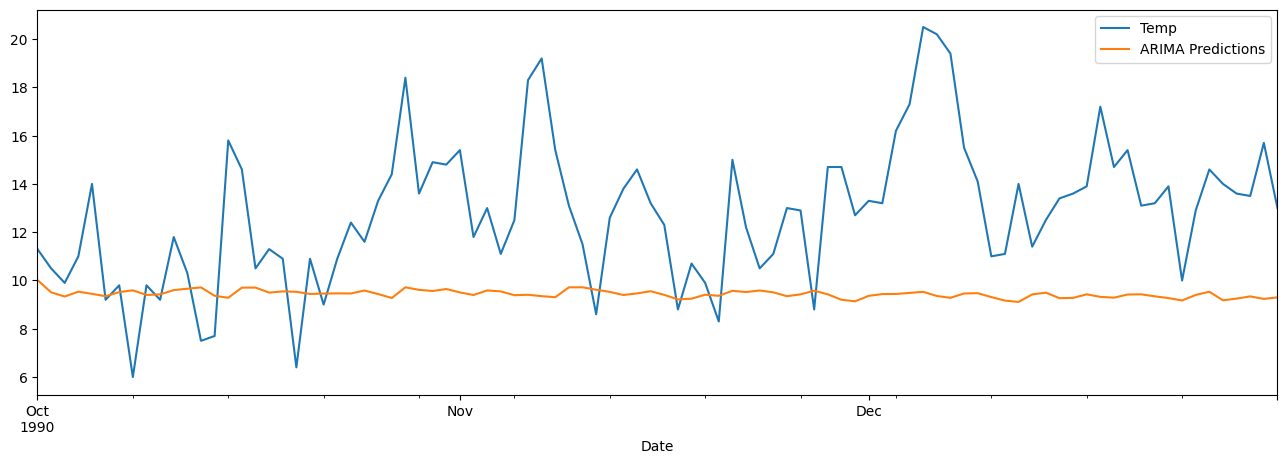

In [17]:
test_data['Temp'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [18]:
arima_rmse_error = rmse(test_data['Temp'], arima_pred)
arima_mse_error = arima_rmse_error**2
arima_mae_error = mean_absolute_error(test_data['Temp'], arima_pred)
mean_value = df['Temp'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 19.710822277604393
RMSE Error: 4.439687182404228
Mean: 11.177753424657535


In [19]:
global_test_data = test_data.copy()
global_test_data['ARIMA_Predictions'] = arima_pred

In [20]:
scaler = MinMaxScaler()

scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [21]:
n_input = 70
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [22]:
#lstm_model = Sequential()
#lstm_model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#lstm_model.add(Dense(1))

lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(n_input, n_features)),
    tf.keras.layers.SimpleRNN(64, return_sequences=True, activation='relu'),
    tf.keras.layers.SimpleRNN(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 70, 64)            4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [23]:
lstm_model.fit_generator(generator,epochs=10)

Epoch 1/10
3488/3488 [==============================] - 99s 28ms/step - loss: 0.0106
Epoch 2/10
3488/3488 [==============================] - 94s 27ms/step - loss: 0.0097
Epoch 3/10
3488/3488 [==============================] - 94s 27ms/step - loss: 0.0094
Epoch 4/10
3488/3488 [==============================] - 94s 27ms/step - loss: 0.0091
Epoch 5/10
3488/3488 [==============================] - 94s 27ms/step - loss: 0.0090
Epoch 6/10
3488/3488 [==============================] - 116s 33ms/step - loss: 0.0090
Epoch 7/10
3488/3488 [==============================] - 96s 27ms/step - loss: 0.0089
Epoch 8/10
3488/3488 [==============================] - 94s 27ms/step - loss: 0.0089
Epoch 9/10
3488/3488 [==============================] - 94s 27ms/step - loss: 0.0090
Epoch 10/10
3488/3488 [==============================] - 94s 27ms/step - loss: 0.0088


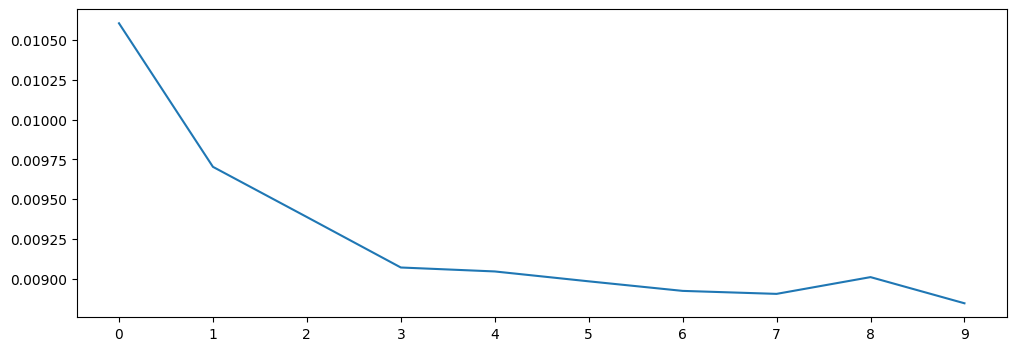

In [24]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [25]:
lstm_predictions_scaled = list()

# last n_input elements
batch = scaled_train_data[-n_input:]
print('batch')
print(batch)
print('shape is ', batch.shape)
# shape now is (1, 12, 1)
current_batch = batch.reshape((1, n_input, n_features))
print('current batch')
print(current_batch)
print('shape is ', current_batch.shape)
for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    # first element in current_batch will be gone
    # a new element will be inserted at the end
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
    print('current_batch now\n', current_batch)
    print('current_batch shape\n', current_batch.shape)

Streaming output truncated to the last 5000 lines.
  [0.39543726]
  [0.14068441]
  [0.27756654]
  [0.44106464]
  [0.61977186]
  [0.36501901]
  [0.25855513]
  [0.19771863]
  [0.40304183]
  [0.61977186]
  [0.37262357]
  [0.17490494]
  [0.42205323]
  [0.33079848]
  [0.38022814]
  [0.39326167]
  [0.40165406]
  [0.40951568]
  [0.41647041]
  [0.4221366 ]
  [0.42683583]
  [0.43100727]
  [0.43478954]
  [0.4382509 ]
  [0.44141686]
  [0.44431192]
  [0.44695723]
  [0.44937426]
  [0.45158261]
  [0.45360029]
  [0.45544386]
  [0.45712823]
  [0.45866728]
  [0.46007341]
  [0.46135825]
  [0.46253216]
  [0.46360475]
  [0.46458483]
  [0.46548027]
  [0.4662984 ]]]
current_batch shape
 (1, 70, 1)
1/1 [==============================] - 0s 25ms/step
current_batch now
 [[[0.29277567]
  [0.33840304]
  [0.36882129]
  [0.37642586]
  [0.23193916]
  [0.25095057]
  [0.28897338]
  [0.28136882]
  [0.30418251]
  [0.07984791]
  [0.2243346 ]
  [0.44106464]
  [0.3269962 ]
  [0.30038023]
  [0.22813688]
  [0.36121673]
  [0

In [26]:
lstm_predictions_scaled

[array([0.39326167], dtype=float32),
 array([0.40165406], dtype=float32),
 array([0.40951568], dtype=float32),
 array([0.4164704], dtype=float32),
 array([0.4221366], dtype=float32),
 array([0.42683583], dtype=float32),
 array([0.43100727], dtype=float32),
 array([0.43478954], dtype=float32),
 array([0.4382509], dtype=float32),
 array([0.44141686], dtype=float32),
 array([0.44431192], dtype=float32),
 array([0.44695723], dtype=float32),
 array([0.44937426], dtype=float32),
 array([0.4515826], dtype=float32),
 array([0.4536003], dtype=float32),
 array([0.45544386], dtype=float32),
 array([0.45712823], dtype=float32),
 array([0.45866728], dtype=float32),
 array([0.4600734], dtype=float32),
 array([0.46135825], dtype=float32),
 array([0.46253216], dtype=float32),
 array([0.46360475], dtype=float32),
 array([0.46458483], dtype=float32),
 array([0.46548027], dtype=float32),
 array([0.4662984], dtype=float32),
 array([0.4670459], dtype=float32),
 array([0.4677289], dtype=float32),
 array([0.

In [27]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [28]:
global_test_data['LSTM_Predictions'] = lstm_predictions

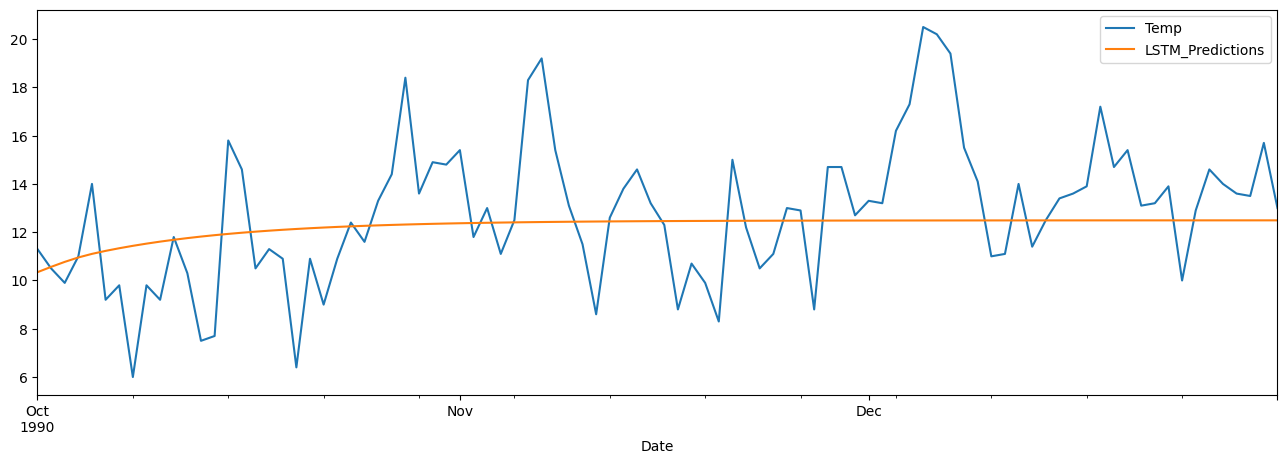

In [29]:
global_test_data['Temp'].plot(figsize = (16,5), legend=True)
global_test_data['LSTM_Predictions'].plot(legend = True);

In [30]:
lstm_rmse_error = rmse(global_test_data['Temp'], global_test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
lstm_mae_error = mean_absolute_error(global_test_data['Temp'], global_test_data["LSTM_Predictions"])
mean_value = df['Temp'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 7.834761543736467
RMSE Error: 2.799064405071178
Mean: 11.177753424657535


In [31]:
rmse_errors = [arima_rmse_error, lstm_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error]
mae_errors = [arima_mae_error, lstm_mae_error]

In [32]:
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors,"MAE Errors": mae_errors})

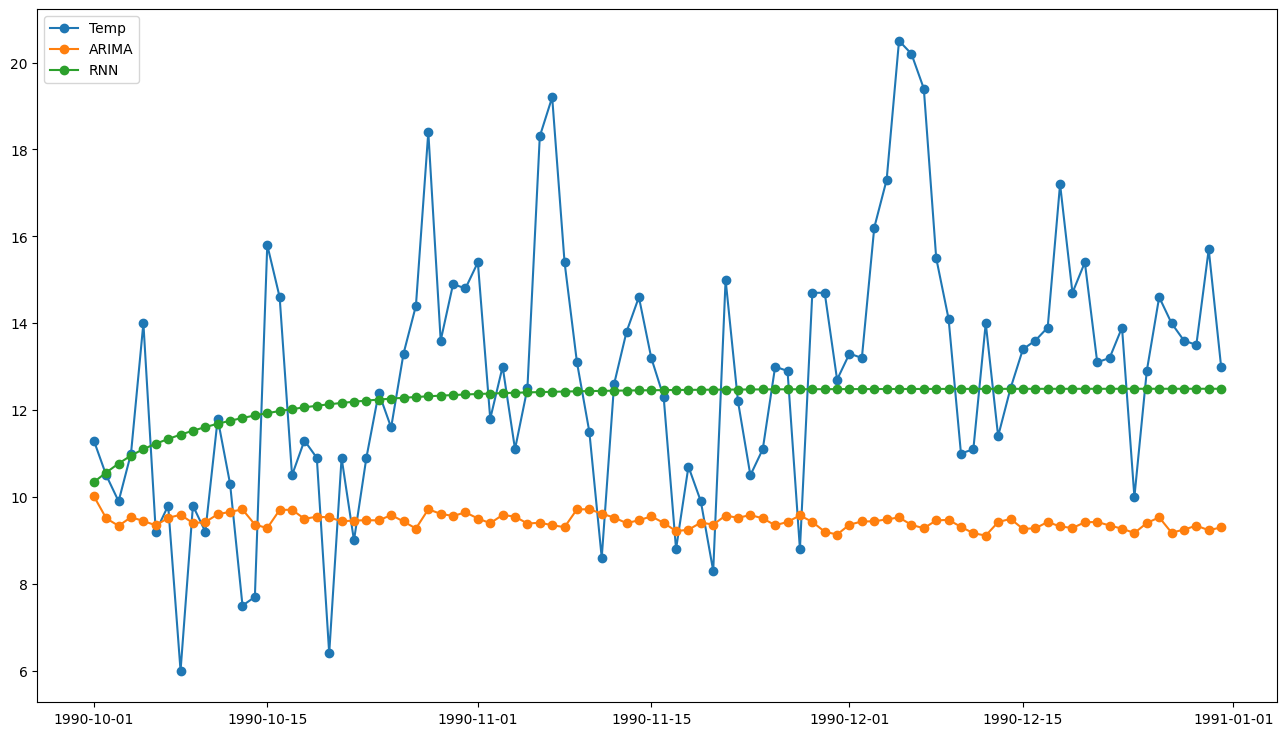

In [33]:
plt.figure(figsize=(16,9))
plt.plot_date(global_test_data.index, global_test_data["Temp"], linestyle="-")
plt.plot_date(global_test_data.index, global_test_data["ARIMA_Predictions"], linestyle="-")
plt.plot_date(global_test_data.index, global_test_data["LSTM_Predictions"], linestyle="-")
plt.legend(["Temp", "ARIMA", 'RNN'], loc ="upper left")
plt.show()

In [34]:
print(f"Mean: {global_test_data['Temp'].mean()}")
errors

Mean: 12.791304347826086


,Models,RMSE Errors,MSE Errors,MAE Errors
0,ARIMA,4.439687,19.710822,3.669713
1,LSTM,2.799064,7.834762,2.128369


In [35]:
global_test_data

,Temp,ARIMA_Predictions,LSTM_Predictions
Date,,,
1990-10-01,11.3,10.019285,10.342782
1990-10-02,10.5,9.508706,10.563502
1990-10-03,9.9,9.335649,10.770262
1990-10-04,11.0,9.535666,10.953172
1990-10-05,14.0,9.446874,11.102193
...,...,...,...
1990-12-27,14.0,9.178731,12.490649
1990-12-28,13.6,9.249061,12.490717
1990-12-29,13.5,9.339950,12.490776
